<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/tripletVAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

In [2]:
# load mnist_fashion dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

In [4]:
# function to show the plot
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
# Training with tshirt/shirt and ankle boot as outlier
## tshirt
image_tshirt_index = np.where(train_labels==0)
train_image_tshirt = train_images[image_tshirt_index]
print("shape before flattening: ",train_image_tshirt.shape)
train_image_tshirt_flatten = np.reshape(train_image_tshirt, (6000, 784))
print("shape after flattening: ",train_image_tshirt_flatten.shape)
## shirt
image_shirt_index = np.where(train_labels==6)
train_image_shirt = train_images[image_shirt_index]
print("shape before flattening: ",train_image_shirt.shape)
train_image_shirt_flatten = np.reshape(train_image_shirt, (6000, 784))
print("shape after flattening: ",train_image_shirt_flatten.shape)

## ankle boot
image_boot_index = np.where(train_labels==9)
train_image_boot = train_images[image_boot_index]
print("shape before flattening: ",train_image_boot.shape)
train_image_boot_flatten = np.reshape(train_image_boot, (6000, 784))
print("shape after flattening: ",train_image_boot_flatten.shape)

shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)
shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)
shape before flattening:  (6000, 28, 28)
shape after flattening:  (6000, 784)


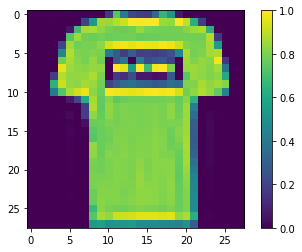

In [6]:
show_image(train_image_tshirt[0])

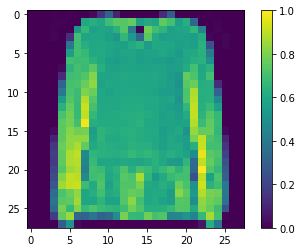

In [7]:
show_image(train_image_shirt[0])

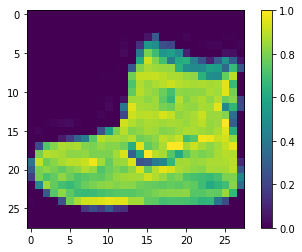

In [8]:
show_image(train_image_boot[0])

In [9]:
# Data for test with tshirt and shoe
## tshirt
image_tshirt_index = np.where(test_labels==0)
test_image_tshirt = test_images[image_tshirt_index]
print("shape before flattening: ",test_image_tshirt.shape)
test_image_tshirt_flatten = np.reshape(test_image_tshirt, (1000, 784))
print("shape after flattening: ",test_image_tshirt_flatten.shape)

## sneaker
image_sneaker_index = np.where(test_labels==7)
test_image_sneaker = test_images[image_sneaker_index]
print("shape before flattening: ",test_image_sneaker.shape)
test_image_sneaker_flatten = np.reshape(test_image_sneaker, (1000, 784))
print("shape after flattening: ",test_image_sneaker_flatten.shape)


shape before flattening:  (1000, 28, 28)
shape after flattening:  (1000, 784)
shape before flattening:  (1000, 28, 28)
shape after flattening:  (1000, 784)


In [10]:
# function to plot a triplet set
def plot_triplet(triplet):
  plt.figure(figsize=(6,2))
  for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [11]:
# concatenating training tshirt , shirt, boot
training_X = np.concatenate((train_image_tshirt_flatten,train_image_shirt_flatten, train_image_boot_flatten), axis = 0)
# concatenating test tshirt and shoe
testing_X = np.concatenate((test_image_tshirt_flatten,test_image_sneaker_flatten), axis = 0)
print("Shape of training dataset: ",training_X.shape)
print("Shape of testing dataset: ",testing_X.shape)

Shape of training dataset:  (18000, 784)
Shape of testing dataset:  (2000, 784)


In [12]:
# generate labels for training dataset tshirt = 0 and trouser = 1
train_y = np.concatenate((np.zeros(2*len(train_image_tshirt_flatten)), np.ones(len(train_image_boot_flatten))), axis=0)

# test generate labels for testing dataser tshirt = 0 and shoe = 1
test_y = np.concatenate((np.zeros(len(test_image_tshirt_flatten)), np.ones(len(test_image_sneaker_flatten))), axis=0)

In [13]:
# Shuffling test data
rng = check_random_state(1)
indices_test = rng.permutation(len(testing_X))
testing_X_shuffled = testing_X[indices_test]
test_y_shuffled = test_y[indices_test]

In [15]:
# Create batches of data for training
def create_batch (batch_size):
  anchors = np.zeros((batch_size, 784))
  positives = np.zeros((batch_size, 784))
  negatives = np.zeros((batch_size, 784))

  for i in range(0,batch_size):
    index = random.randint(0,6000-1)
    anc = training_X[index]
    y = train_y[index]

    indices_for_pos = np.squeeze(np.where(train_y == y))
    indices_for_neg = np.squeeze(np.where(train_y != y))

    pos = training_X[indices_for_pos[random.randint(0,len(indices_for_pos)-1)]]
    neg = training_X[indices_for_neg[random.randint(0,len(indices_for_neg)-1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg

    return [anchors, positives, negatives] 

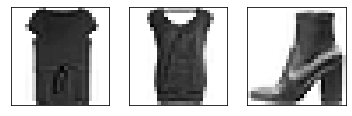

In [16]:
triplet = create_batch (1)
plot_triplet(triplet)

In [17]:
# Defining Sampling function
encoding_dim = 64
def sampling(args):
    mu, sigma = args
    batch     = tf.shape(mu)[0]
    dim       = tf.shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(sigma / 2) * eps

In [18]:
# Defining Encoder
class _Encoder(Model):
    def __init__(self, **kwargs):
        super(_Encoder, self).__init__(**kwargs)
        self.layer_1 = Dense(256, activation="relu")
        self.layer_2 = Dense(128, activation="relu")
        self.layer_3 = Dense(64, activation="relu")
    
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        self.mean = Dense(encoding_dim, name="z_mean")(x)
        self.log_var = Dense(encoding_dim, name="z_log_var")(x)
        self.z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([self.mean, self.log_var])
        return self.z, self.mean, self.log_var

In [19]:
# Defining Decoder
class _Decoder(Model):
    def __init__(self, **kwargs):
        super(_Decoder, self).__init__(**kwargs)
        self.layer_1 = Dense(128, activation="relu")
        self.layer_2 = Dense(256, activation="relu")
        self.layer_3 = Dense(784, activation="sigmoid")
        
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        output = self.layer_3(x)
        return output


In [20]:
# kl divergence loss
# https://keras.io/examples/generative/vae/

def kl_reconstruction_loss(x, recon_x, mu, log_var):
    reco_loss = tf.reduce_sum(tf.pow(x - recon_x,2), axis= -1)
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis= -1)
    kl_loss *= -0.5
    return tf.reduce_mean(reco_loss + kl_loss)

In [31]:
# Defining model parameters
batch_size= 600
steps = int(18000/batch_size)
encoder = _Encoder()
decoder = _Decoder()
alpha = 0.2
optimizer = tf.keras.optimizers.Adam(lr=0.001,clipvalue=0.5)

In [32]:
def Callback_EarlyStopping(LossList, min_delta=0.1, patience=5):
    #No early stopping for 2*patience epochs 
    if len(LossList)//patience < 2 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(LossList[::-1][patience:2*patience]) #second-last
    mean_recent = np.mean(LossList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta_abs = np.abs(mean_recent - mean_previous) #abs change
    delta_abs = np.abs(delta_abs / mean_previous)  # relative change
    if delta_abs < min_delta :
        print("Loss didn't change much from last %d epochs"%(patience))
        print("Percent change in loss value:", delta_abs*1e2)
        return True
    else:
        return False


In [33]:
epochs = 40
epochs_train_losses = []
for epoch in range(epochs):
  print('Start of epoch',epoch)
  losses = []
  for step in range(0,steps):
    #print('Step: ', step)
    anc, pos, neg = create_batch (batch_size)
    anc_pos = np.concatenate((anc,pos), axis = 0)
    #print("anc.shape:",anc.shape)
    #print("pos.shape:",pos.shape)
    #print("neg.shape:",neg.shape)
    with tf.GradientTape() as tape:
      latent_anc,mean_anc,log_var_anc = encoder(anc)
      latent_pos,mean_pos,log_var_pos = encoder(pos)
      latent_neg,mean_neg,log_var_neg = encoder(neg)
      latent_anc_pos = np.concatenate((latent_anc,latent_pos), axis = 0)
      mean_anc_pos = np.concatenate((mean_anc,mean_pos), axis = 0)
      log_var_anc_pos = np.concatenate((log_var_anc,log_var_pos), axis = 0)
      dp = tf.reduce_mean(tf.square(mean_anc - mean_pos), axis = -1)
      dn = tf.reduce_mean(tf.square(mean_anc - mean_neg), axis = -1)
      triplet_loss = tf.maximum(dp-dn+alpha, 0.)
      reconstructed_anc_pos = decoder(latent_anc_pos)
      #reconstructed_p = decoder(mean_pos)
      loss = triplet_loss
      loss+= kl_reconstruction_loss(anc_pos, reconstructed_anc_pos, mean_anc_pos, log_var_anc_pos)
      tvae_weights = encoder.trainable_weights + decoder.trainable_weights
    gradients = tape.gradient(loss, tvae_weights)
    # Calculate gradients
    optimizer.apply_gradients(zip(gradients, tvae_weights))
    losses.append(loss)
    #print("losses: ", len(losses))
  epochs_train_losses.append(tf.reduce_mean(losses))
  print("epochs_train_losses:", epochs_train_losses[epoch] )
  early_stopping = Callback_EarlyStopping(epochs_train_losses, min_delta=0.1, patience=5)
  if early_stopping:
    print("Callback_EarlyStopping signal received at epoch= %d/%d"%(epoch,epochs))
    print("Terminating training ")
    break

Start of epoch 0
epochs_train_losses: tf.Tensor(58.91048, shape=(), dtype=float32)
Start of epoch 1
epochs_train_losses: tf.Tensor(0.5250881, shape=(), dtype=float32)
Start of epoch 2
epochs_train_losses: tf.Tensor(0.5179636, shape=(), dtype=float32)
Start of epoch 3
epochs_train_losses: tf.Tensor(0.63652176, shape=(), dtype=float32)
Start of epoch 4
epochs_train_losses: tf.Tensor(0.65864813, shape=(), dtype=float32)
Start of epoch 5
epochs_train_losses: tf.Tensor(0.6263341, shape=(), dtype=float32)
Start of epoch 6
epochs_train_losses: tf.Tensor(0.60370976, shape=(), dtype=float32)
Start of epoch 7
epochs_train_losses: tf.Tensor(0.6303368, shape=(), dtype=float32)
Start of epoch 8
epochs_train_losses: tf.Tensor(0.58236045, shape=(), dtype=float32)
Start of epoch 9
epochs_train_losses: tf.Tensor(0.5056137, shape=(), dtype=float32)
Start of epoch 10
epochs_train_losses: tf.Tensor(0.5335651, shape=(), dtype=float32)
Loss didn't change much from last 5 epochs
Percent change in loss value:

<function matplotlib.pyplot.show>

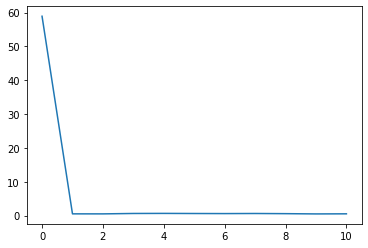

In [34]:
plt.plot(epochs_train_losses)
plt.show

In [35]:
# Prediction
encoded,_,_ = encoder(testing_X_shuffled)
decoded = decoder(encoded)
decoded_output = decoded.numpy()

In [36]:
# Reconstruction loss
MSE_loss = np.mean(np.power(testing_X_shuffled - decoded_output, 2), axis=1)

In [37]:
MSE_loss.shape

(2000,)

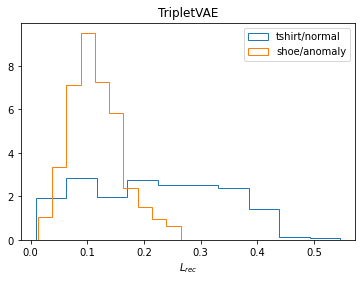

In [38]:
l_rec_0=[]
l_rec_1=[]

for i in range(1000):
    if test_y_shuffled[i]==0:
        l_rec_0.append(MSE_loss[i])
    else:
        l_rec_1.append(MSE_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='tshirt/normal', density='true')
plt.hist(l_rec_1, histtype='step', label='shoe/anomaly', density='true')
plt.legend(loc='best')
plt.title('TripletVAE')
plt.xlabel('$L_{rec}$')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.21754400000000002


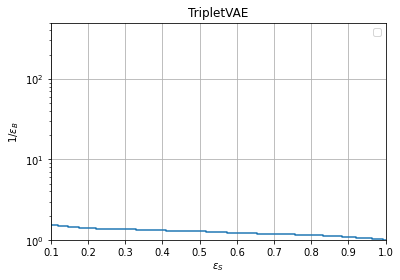

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(test_y_shuffled, MSE_loss)
print("roc_auc =", roc_auc_score(test_y_shuffled, MSE_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('TripletVAE')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()